<a href="https://colab.research.google.com/github/jfarrell8/WQU_5457/blob/main/Capstone_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Packages

In [4]:
!pip install --upgrade pip

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


In [ ]:
# install finrl library
%%capture

!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
%%capture
!pip install yfinance
!pip install edgartools
!pip install py-xbrl

In [ ]:
!pip install -Uqq ipdb
import ipdb

In [1]:
import yfinance as yf
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import random
import cvxpy
# from cvxpy import *
import gym
from gym.utils import seeding
from gym import spaces
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from stable_baselines3.common.vec_env import DummyVecEnv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'finrl'

# Data Wrangling

We decided to look at diversifying our portfolio constituents rather than specifically focusing on mining companies. We're going to look at the S&P 500 Dividend Aristocrats. This is an index of the S&P 500 constituents that have increased their dividend yearly for at least the last 25 years. As of today, 03/26/2024, there are 67 companies in this index. Note that this is not a point-in-time representation of the index. Rather, we're taking the current list of 67 constituents, and building our own index with these 67 diversified companies from a past start time.

In [ ]:
sp_da = pd.read_html('https://en.wikipedia.org/wiki/S%26P_500_Dividend_Aristocrats')[0]
tickers = sp_da['Ticker symbol'].str.replace('.', '-').tolist()

# View sector distribution
sector_distribution = pd.DataFrame(sp_da.groupby(['Sector']).count()['Company'])

sector_distribution.loc['TOTAL'] = sector_distribution.sum()

sector_distribution

,Company
Sector,
Consumer Discretionary,4
Consumer Staples,15
Energy,2
Financials,7
Health Care,7
Industrials,16
Information Technology,2
Materials,8
Real Estate,3


As of today, the dividend aristocrats include 67 companies in 10 sectors. This shows that diversification is feasible within that group of assets.

In [ ]:
start_date = "2000-01-01"
end_date = "2024-04-07"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True)['Close']

data

[*********************100%%**********************]  67 of 67 completed


Ticker,ABBV,ABT,ADM,ADP,AFL,ALB,AMCR,AOS,APD,ATO,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,8.99,6.41,24.78,6.92,6.17,NaN,2.34,17.21,8.03,...,4.60,9.56,18.91,15.58,10.29,22.67,9.41,14.47,5.43,18.33
2000-01-04,NaN,8.74,6.35,24.78,6.73,6.17,NaN,2.31,16.69,7.83,...,4.43,9.44,18.04,15.24,9.97,21.69,9.13,13.93,5.48,17.98
2000-01-05,NaN,8.72,6.25,24.54,6.70,6.28,NaN,2.30,16.79,8.08,...,4.44,9.37,17.80,15.04,10.09,21.20,9.11,13.64,5.46,18.96
2000-01-06,NaN,9.02,6.28,24.87,6.83,6.49,NaN,2.27,17.90,7.96,...,4.51,9.56,17.31,14.97,10.51,20.19,9.38,13.79,5.40,19.94
2000-01-07,NaN,9.12,6.38,25.44,6.97,6.39,NaN,2.36,19.15,8.03,...,4.46,9.62,17.47,15.24,10.53,21.24,9.31,14.83,5.46,19.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,179.09,111.54,62.35,245.31,85.19,129.18,9.45,89.08,243.42,117.85,...,338.16,124.73,427.09,95.46,80.07,177.82,120.30,60.00,395.73,116.99
2024-04-02,179.02,111.47,62.70,247.66,84.93,126.48,9.31,88.55,239.84,117.77,...,333.96,123.06,426.11,94.49,79.93,176.24,118.55,59.16,387.69,119.28
2024-04-03,175.69,110.73,62.65,245.13,85.18,128.87,9.18,88.65,239.60,116.97,...,334.29,119.52,426.46,96.24,79.45,175.49,118.49,59.43,386.94,119.30


et's try to identify start and end dates for each of these constituents to determine if we feel like there's enough data for each

In [ ]:
price_date_range = pd.DataFrame()
price_date_range['Start Date'] = data.apply(lambda x:x.first_valid_index())
price_date_range['End Date'] = data.apply(lambda x:x.last_valid_index())

price_date_range.sort_values(by='Start Date', ascending=False)

,Start Date,End Date
Ticker,,
KVUE,2023-05-04,2024-04-05
ABBV,2013-01-02,2024-04-05
AMCR,2012-05-15,2024-04-05
IBM,2000-01-03,2024-04-05
ITW,2000-01-03,2024-04-05
...,...,...
ESS,2000-01-03,2024-04-05
EXPD,2000-01-03,2024-04-05
FAST,2000-01-03,2024-04-05


Count how many tickers don't have data available until the end of the period.

In [ ]:
# any tickers that get dropped before the current EndDate
data.iloc[-1].isnull().sum()

0

Drop all tickers that start later than 2000-01-03 or have no data until the end of the period. Update `tickers` variable.

In [ ]:
data = data.loc[:, data.iloc[-1].notnull() & data.iloc[0].notnull()]
tickers = list(data.columns)

data # should be 64 columns now

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,8.99,6.41,24.78,6.92,6.17,2.34,17.21,8.03,17.60,5.68,...,4.60,9.56,18.91,15.58,10.29,22.67,9.41,14.47,5.43,18.33
2000-01-04,8.74,6.35,24.78,6.73,6.17,2.31,16.69,7.83,17.14,5.58,...,4.43,9.44,18.04,15.24,9.97,21.69,9.13,13.93,5.48,17.98
2000-01-05,8.72,6.25,24.54,6.70,6.28,2.30,16.79,8.08,17.26,5.67,...,4.44,9.37,17.80,15.04,10.09,21.20,9.11,13.64,5.46,18.96
2000-01-06,9.02,6.28,24.87,6.83,6.49,2.27,17.90,7.96,17.98,6.01,...,4.51,9.56,17.31,14.97,10.51,20.19,9.38,13.79,5.40,19.94
2000-01-07,9.12,6.38,25.44,6.97,6.39,2.36,19.15,8.03,18.98,6.06,...,4.46,9.62,17.47,15.24,10.53,21.24,9.31,14.83,5.46,19.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,111.54,62.35,245.31,85.19,129.18,89.08,243.42,117.85,244.05,27.62,...,338.16,124.73,427.09,95.46,80.07,177.82,120.30,60.00,395.73,116.99
2024-04-02,111.47,62.70,247.66,84.93,126.48,88.55,239.84,117.77,241.02,27.28,...,333.96,123.06,426.11,94.49,79.93,176.24,118.55,59.16,387.69,119.28
2024-04-03,110.73,62.65,245.13,85.18,128.87,88.65,239.60,116.97,243.59,27.50,...,334.29,119.52,426.46,96.24,79.45,175.49,118.49,59.43,386.94,119.30


In [ ]:
# let's turn prices into log returns
rets = np.log(data).diff()
rets = rets.dropna()
rets

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.03,-0.01,0.00,-0.03,0.00,-0.01,-0.03,-0.03,-0.03,-0.02,...,-0.04,-0.01,-0.05,-0.02,-0.03,-0.04,-0.03,-0.04,0.01,-0.02
2000-01-05,-0.00,-0.02,-0.01,-0.01,0.02,-0.00,0.01,0.03,0.01,0.02,...,0.00,-0.01,-0.01,-0.01,0.01,-0.02,-0.00,-0.02,-0.00,0.05
2000-01-06,0.03,0.01,0.01,0.02,0.03,-0.01,0.06,-0.02,0.04,0.06,...,0.02,0.02,-0.03,-0.00,0.04,-0.05,0.03,0.01,-0.01,0.05
2000-01-07,0.01,0.02,0.02,0.02,-0.02,0.04,0.07,0.01,0.05,0.01,...,-0.01,0.01,0.01,0.02,0.00,0.05,-0.01,0.07,0.01,-0.00
2000-01-10,-0.01,0.00,0.02,-0.06,-0.00,0.01,-0.06,-0.01,-0.02,0.01,...,-0.02,-0.01,0.07,-0.01,0.00,-0.02,0.01,-0.02,0.02,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.01,-0.01,-0.02,-0.01,-0.02,-0.00,0.00,-0.01,-0.01,-0.02,...,-0.03,-0.01,0.00,-0.03,-0.01,0.00,-0.01,-0.00,0.00,0.01
2024-04-02,-0.00,0.01,0.01,-0.00,-0.02,-0.01,-0.01,-0.00,-0.01,-0.01,...,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.01,-0.01,-0.02,0.02
2024-04-03,-0.01,-0.00,-0.01,0.00,0.02,0.00,-0.00,-0.01,0.01,0.01,...,0.00,-0.03,0.00,0.02,-0.01,-0.00,-0.00,0.00,-0.00,0.00


# Include additional data

In [ ]:
# first need to pivot the rets df
rets_long = pd.DataFrame(rets.stack())
rets_long = rets_long.reset_index()
rets_long = rets_long.rename(columns={0: 'ret'})
rets_long.head()

,Date,Ticker,ret
0,2000-01-04,ABT,-0.03
1,2000-01-04,ADM,-0.01
2,2000-01-04,ADP,0.00
3,2000-01-04,AFL,-0.03
4,2000-01-04,ALB,0.00


## Fundamentals

In [ ]:
root_dir = "/content/drive/My Drive/CapstoneProject/data/fundamental"

In [ ]:
# dividend yield = dividends per share/current share price --> dividendPayout and commonStockSharesOutstanding and price from yfinance
# payout ratio = total dividends / net income --> dividendPayout and netIncome
# operating cash flow ratio = operating cash flow / net revenue --> operatingCashflow and totalRevenue and costOfRevenue
# return on assets = net income / total assets --> netIncome and totalAssets
# net profit margin = net income / revenue --> netIncome and totalRevenue

In [ ]:
# let's look at a few tickers first before we try to combine everything
tic = 'MMM'
income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
df = df.sort_values('fiscalDateEnding')
df.head(6)

,fiscalDateEnding,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome_y
0,2008-06-30,3229000000,6739000000,3510000000,3510000000,1449000000,1394000000,363000000,1757000000,NaN,...,351000000,NaN,NaN,NaN,NaN,-572000000.00,NaN,NaN,NaN,945000000
1,2008-09-30,3126000000,6558000000,3432000000,3432000000,1513000000,1269000000,344000000,1613000000,NaN,...,348000000,NaN,NaN,NaN,NaN,-515000000.00,40000000.00,693000000.00,-147000000.00,991000000
2,2008-12-31,2408000000,5509000000,3101000000,3101000000,755000000,1307000000,346000000,1653000000,NaN,...,346000000,NaN,NaN,NaN,NaN,-34000000.00,32000000.00,-391000000.00,-263000000.00,536000000
3,2009-03-31,2317000000,5089000000,2772000000,2772000000,803000000,1191000000,323000000,1514000000,NaN,...,354000000,NaN,NaN,NaN,NaN,NaN,34000000.00,-217000000.00,13000000.00,518000000
4,2009-06-30,2742000000,5719000000,2977000000,2977000000,1191000000,1242000000,309000000,1242000000,NaN,...,355000000,NaN,NaN,NaN,NaN,-6000000.00,191000000.00,964000000.00,75000000.00,783000000
5,2009-09-30,3022000000,6193000000,3171000000,3171000000,1478000000,1209000000,335000000,1209000000,NaN,...,361000000,NaN,NaN,NaN,NaN,62000000.00,66000000.00,643000000.00,-102000000.00,957000000


In [ ]:
tic = 'MKC'
income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
df = df.sort_values('fiscalDateEnding')
df.head(6)

,fiscalDateEnding,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome_y
0,2009-08-31,319000000,791700000,472700000,472700000,116600000,201500000,NaN,201500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-11-30,421700000,924600000,502900000,502900000,177900000,238300000,48900000.00,238300000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-28,310200000,764500000,454300000,454300000,100800000,209400000,NaN,209400000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-05-31,326700000,798300000,471600000,471600000,97500000,229200000,NaN,229200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-08-31,334800000,782200000,668600000,459800000,126000000,208800000,NaN,221200000,NaN,...,34700000.00,NaN,NaN,NaN,NaN,-31800000.00,NaN,500000.00,15600000.00,102400000.00
5,2010-11-30,446000000,979500000,794000000,533400000,185400000,260600000,52700000.00,272800000,NaN,...,34500000.00,NaN,NaN,NaN,NaN,-16600000.00,NaN,27200000.00,16600000.00,133600000.00


## We notice a few things


*   Time scales are different (notice that MMM reported on 2009-09-30 and MKC reported on 2009-08-31)
*   They have a much later time start than our price data.
*   They have different start dates.
*   They have different amounts of NaN at different features.

The first bullet will be handled with re-scaling the data. The remaining bullets will all affect our ultimate start date, and we'll have to getter a better sense for the data available in the other tickers.

In [ ]:
master_df = pd.DataFrame()

for tic in tickers:
  print(f'Processing {tic}...')
  income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
  balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
  cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
  df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
  df = df.rename(columns={'fiscalDateEnding': 'Date'})
  df = df.sort_values('Date')
  df.set_index('Date', inplace=True)
  df.index = pd.to_datetime(df.index)
  df = df.resample('Q').last() # resample to quarters so datasets all match

  data_items_needed = ['dividendPayout', 'commonStockSharesOutstanding', 'netIncome_x', 'operatingCashflow', 'totalRevenue', 'costOfRevenue', 'totalAssets']

  subset_df = df[data_items_needed]
  subset_df = pd.merge(subset_df, data[[tic]], on='Date')
  subset_df = subset_df.rename(columns={tic: 'Price'})

  # calculate factors
  subset_df['dividendYield'] = subset_df.dividendPayout / subset_df.commonStockSharesOutstanding / subset_df.Price
  subset_df['payoutRatio'] = subset_df.dividendPayout / subset_df.netIncome_x
  subset_df['operatingcashFlowRatio'] = subset_df.operatingCashflow / (subset_df.totalRevenue - subset_df.costOfRevenue)
  subset_df['ROA'] = subset_df.netIncome_x / subset_df.totalAssets
  subset_df['netProfitMargin'] = subset_df.netIncome_x / subset_df.totalRevenue
  subset_df['ticker'] = tic

  subset_df.drop(['Price'] + data_items_needed, axis=1, inplace=True)

  master_df = pd.concat([master_df, subset_df], axis=0)
  master_df = master_df.sort_values(by=['Date', 'ticker'])

In [ ]:
master_df.head(3)

,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,ticker
Date,,,,,,
2008-03-31,NaN,NaN,NaN,NaN,NaN,ABT
2008-03-31,NaN,NaN,NaN,NaN,NaN,BF-B
2008-03-31,NaN,NaN,NaN,NaN,0.08,CVX


In [ ]:
master_df.groupby('Date')['ticker'].nunique() # 62 companies starting at 2009-09-30. seems decent

Date
2008-03-31     4
2008-06-30    32
2008-09-30    42
2008-12-31    42
2009-03-31    44
2009-06-30    57
2009-09-30    62
2009-12-31    62
2010-03-31    62
2010-06-30    62
2010-09-30    62
2010-12-31    62
2011-03-31    62
2011-06-30    62
2011-09-30    62
2012-12-31    62
2013-09-30    63
2013-12-31    63
2014-03-31    63
2014-06-30    63
2014-09-30    63
2014-12-31    63
2015-03-31    63
2015-06-30    63
2015-09-30    63
2015-12-31    63
2016-03-31    63
2016-06-30    63
2016-09-30    63
2017-03-31    64
2017-06-30    64
2018-12-31    64
2019-09-30    64
2019-12-31    64
2020-03-31    64
2020-06-30    64
2020-09-30    64
2020-12-31    64
2021-03-31    64
2021-06-30    64
2021-09-30    64
2021-12-31    64
2022-03-31    64
2022-06-30    64
2022-09-30    64
2023-03-31    64
2023-06-30    64
Name: ticker, dtype: int64

In [ ]:
# let's look at the constituents by date
date_check = master_df.reset_index()
date_check = date_check.groupby('ticker').agg({'Date':['min', 'max']})

In [ ]:
date_check[('Date', 'max')].unique() # so constituents aren't in-and-out. once in they're there.

<DatetimeArray>
['2023-06-30 00:00:00']
Length: 1, dtype: datetime64[ns]

In [ ]:
date_check.sort_values(('Date', 'min'))

Date           
              min        max
ticker                      
ABT    2008-03-31 2023-06-30
BF-B   2008-03-31 2023-06-30
CVX    2008-03-31 2023-06-30
TROW   2008-03-31 2023-06-30
EMR    2008-06-30 2023-06-30
...           ...        ...
HRL    2009-09-30 2023-06-30
SJM    2009-09-30 2023-06-30
MKC    2009-09-30 2023-06-30
MDT    2013-09-30 2023-06-30
LIN    2017-03-31 2023-06-30

[64 rows x 2 columns]

In [ ]:
# Let's now start at '2009-09-30' and get rid of MDT and LIN

In [ ]:
new_start_date = '2009-09-30'

In [ ]:
keep_tickers = master_df.loc[new_start_date]['ticker'].tolist()
x_tickers = set(tickers).intersection(set(keep_tickers))
miss_tickers = set(tickers).difference(set(keep_tickers))
print(miss_tickers)
print(len(x_tickers))

{'LIN', 'MDT'}
62


In [ ]:
new_df = master_df.loc[new_start_date:]
fundamental_df = new_df[~new_df['ticker'].isin(['MDT', 'LIN'])]
fundamental_df = fundamental_df.rename(columns={'ticker': 'Ticker'})
fundamental_df.head()

,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,Ticker
Date,,,,,,
2009-09-30,0.02,0.42,1.39,0.03,0.19,ABT
2009-09-30,0.01,0.18,2.05,0.02,0.03,ADM
2009-09-30,0.01,0.58,0.27,0.01,0.14,ADP
2009-09-30,0.02,0.36,-0.78,0.00,0.08,AFL
2009-09-30,NaN,0.22,1.14,NaN,0.10,ALB


In [ ]:
# let's just check that they're gone
print('MDT' in fundamental_df.Ticker.unique())
print('LIN' in fundamental_df.Ticker.unique())

False
False


In [ ]:
# get number of missing values at each date
pd.DataFrame(master_df.groupby('Date').apply(lambda x: x.isnull().sum()))

,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,ticker
Date,,,,,,
2008-03-31,4,4,4,4,3,0
2008-06-30,32,21,21,32,7,0
2008-09-30,42,29,29,42,9,0
2008-12-31,42,25,25,42,10,0
2009-03-31,43,24,23,43,9,0
2009-06-30,24,15,16,24,6,0
2009-09-30,20,11,11,19,2,0
2009-12-31,19,12,12,19,5,0
2010-03-31,19,10,10,19,3,0


In [ ]:
# might want to have a start date of 2010-06-30....which would still have the same 62 tickers

In [ ]:
fundamental_df.set_index(['Ticker'], append=True, inplace=True)
fundamental_df = fundamental_df.loc['2010-06-30':]
fundamental_df = fundamental_df.ffill().bfill()

In [ ]:
fundamental_df

dividendYield  payoutRatio  operatingcashFlowRatio  ROA  \
Date       Ticker                                                            
2010-06-30 ABT              0.03         0.53                    0.96 0.02   
           ADM              0.01         0.22                   -0.10 0.01   
           ADP              0.01         0.84                    0.44 0.01   
           AFL              0.02         0.23                   -1.34 0.01   
           ALB              0.00         0.16                    0.96 0.03   
...                          ...          ...                     ...  ...   
2023-06-30 TGT              0.01         0.52                    1.07 0.02   
           TROW             0.01         0.59                    0.49 0.04   
           WMT              0.01         0.92                    0.13 0.01   
           WST              0.00         0.09                    0.86 0.04   
           XOM              0.01         0.49                    0.12 0.02   

                   netProfitMargin  
Date       Ticker                   
2010-06-30 ABT                0.15  
           ADM                0.03  
           ADP                0.09  
           AFL                0.12  
           ALB                0.14  
...                            ...  
2023-06-30 TGT                0.04  
           TROW               0.30  
           WMT                0.01  
           WST                0.21  
           XOM                0.10  

[2356 rows x 5 columns]

In [ ]:
monthly_ff = fundamental_df.reset_index(level=['Ticker'])
monthly_ff = monthly_ff.groupby(['Ticker']).resample('M').ffill()
monthly_ff.drop('Ticker', axis=1, inplace=True)

<ipython-input-32-b96b0517d0a4>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ff = monthly_ff.groupby(['Ticker']).resample('M').ffill()


In [ ]:
monthly_ff.head()

dividendYield  payoutRatio  operatingcashFlowRatio  ROA  \
Ticker Date                                                                  
ABT    2010-06-30           0.03         0.53                    0.96 0.02   
       2010-07-31           0.03         0.53                    0.96 0.02   
       2010-08-31           0.03         0.53                    0.96 0.02   
       2010-09-30           0.02         0.76                    1.20 0.02   
       2010-10-31           0.02         0.76                    1.20 0.02   

                   netProfitMargin  
Ticker Date                         
ABT    2010-06-30             0.15  
       2010-07-31             0.15  
       2010-08-31             0.15  
       2010-09-30             0.10  
       2010-10-31             0.10

In [ ]:
monthly_ff.index.get_level_values(1).unique() # so we should have 157 rows for the final dataset

DatetimeIndex(['2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
               '2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31',
               ...
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=157, freq=None)

## Bond Yield Curves

Yield curves of U.S. Treasuries were obtained from treasury.gov for the period between 2000 and 2023 for all available maturities.

Since the number of available maturities varied over time, polynomial interpolation with 4th-degree polynomials was used to harmonize the sampling among all curves. A total of four points per polynomial were obtained.

In [ ]:
# use cached version
yield_curve = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/master_yield_curve.csv", index_col='Date')
yield_curve.index = pd.to_datetime(yield_curve.index)

def fit_polynomial(yield_curve, degree=4):
    """Fits polynomials to an yield curve in a dataframe."""

    rates = yield_curve.dropna()
    maturities = np.array([(int(i[:-3])/12 if i[-2:] == 'Mo' else int(i[:-3])) for i in rates.index])

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    poly_features = poly.fit_transform(maturities.reshape(-1, 1))

    # Fit polynomial regression model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, rates)

    return poly_reg_model

def fit_polynomials(yield_curves, degree=4):
    "Fits polynomials to all yield curves in a dataframe."
    df = pd.DataFrame(index=yield_curves.index,columns=range(degree + 1))
    for curve in yield_curves.index:
        model = fit_polynomial(yield_curves.loc[curve,:])
        df.loc[curve, 0] = model.intercept_
        df.loc[curve, 1:] = model.coef_
    return df

def resample_yield_curves(x, polynomials):
    "Resamples a series of polynomials at specified intervals."
    return np.apply_along_axis(lambda p:np.polyval(p, x), 1, polynomials)

interpolating_polynomials = fit_polynomials(yield_curve)

x_values = np.array([0.1, 0.3, 0.6, 0.9])

resampled_curves = resample_yield_curves(x_values, interpolating_polynomials)

NameError: name 'pd' is not defined

In [ ]:
# Tidy up dataframe
yield_m = pd.DataFrame(resampled_curves, index=yield_curve.index, columns=x_values)
yield_m.index = pd.to_datetime(yield_m.index)

yield_m.sort_index(inplace=True)

# Apply log difference
yield_m = np.log(yield_m).diff()
yield_m = yield_m.dropna()
yield_m

In [ ]:
##### JOHN VERSION TO KEEP MOVING ####
# use cached version
yield_curve = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/master_yield_curve.csv", index_col='Date')
yield_curve.index = pd.to_datetime(yield_curve.index)
yield_curve = yield_curve[['1 Yr', '3 Yr']]
yield_m = yield_curve.resample('M').last()

<ipython-input-36-82e872941be9>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  yield_m = yield_curve.resample('M').last()


## Merging the datasets together

In [ ]:
# need monthly returns from original price data
data_m = data.resample('M').last()
rets_m = np.log(data_m).diff()
rets_m = rets_m.dropna()
rets_m_long = pd.DataFrame(rets_m.stack())
rets_m_long = rets_m_long.reset_index()
rets_m_long = rets_m_long.rename(columns={0: 'ret'})
rets_m_long

<ipython-input-37-85650b6846b3>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_m = data.resample('M').last()


,Date,Ticker,ret
0,2000-02-29,ABT,0.01
1,2000-02-29,ADM,-0.15
2,2000-02-29,ADP,-0.09
3,2000-02-29,AFL,-0.17
4,2000-02-29,ALB,-0.18
...,...,...,...
18619,2024-04-30,TGT,-0.03
18620,2024-04-30,TROW,-0.04
18621,2024-04-30,WMT,-0.01
18622,2024-04-30,WST,-0.00


In [147]:
# data_m.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/monthly_prices.csv")

In [149]:
data_m.index

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29',
               '2024-03-31', '2024-04-30'],
              dtype='datetime64[ns]', name='Date', length=292, freq='ME')

In [ ]:
# merge to final dataset
dataset = rets_m_long.merge(monthly_ff, on=['Date', 'Ticker']).merge(yield_m, on='Date')
dataset

,Date,Ticker,ret,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr
0,2010-06-30,ABT,-0.02,0.03,0.53,0.96,0.02,0.15,0.32,1.00
1,2010-06-30,ADM,0.02,0.01,0.22,-0.10,0.01,0.03,0.32,1.00
2,2010-06-30,ADP,-0.01,0.01,0.84,0.44,0.01,0.09,0.32,1.00
3,2010-06-30,AFL,-0.04,0.02,0.23,-1.34,0.01,0.12,0.32,1.00
4,2010-06-30,ALB,-0.08,0.00,0.16,0.96,0.03,0.14,0.32,1.00
...,...,...,...,...,...,...,...,...,...,...
9729,2023-06-30,TGT,0.01,0.01,0.52,1.07,0.02,0.04,5.40,4.49
9730,2023-06-30,TROW,0.06,0.01,0.59,0.49,0.04,0.30,5.40,4.49
9731,2023-06-30,WMT,0.07,0.01,0.92,0.13,0.01,0.01,5.40,4.49
9732,2023-06-30,WST,0.13,0.00,0.09,0.86,0.04,0.21,5.40,4.49


In [132]:
# dataset.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/dataset.csv", index=False)

In [134]:
dataset.dtypes

Date                      datetime64[ns]
Ticker                            object
ret                              float64
dividendYield                    float64
payoutRatio                      float64
operatingcashFlowRatio           float64
ROA                              float64
netProfitMargin                  float64
1 Yr                             float64
3 Yr                             float64
dtype: object

In [ ]:
# quick check
print(dataset.Date.nunique())
print(dataset.Ticker.nunique())

157
62


# Data Visualization

In [ ]:
# subplots of line plots for each price

In [ ]:
# subplots of line plots for each return

In [ ]:
# analyze and potentially remove some tickers if need be

# Modeling

## MVO

In [ ]:
# get annualized expected returns and covariance matrix
rets_exp = rets.mean()*252
rets_cov = rets.cov()*252

In [ ]:
rets_exp

Ticker
ABT    0.10
ADM    0.09
ADP    0.09
AFL    0.10
ALB    0.12
       ... 
TGT    0.08
TROW   0.10
WMT    0.06
WST    0.18
XOM    0.08
Length: 64, dtype: float64

In [ ]:
rets_cov

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
ABT,0.06,0.02,0.02,0.03,0.03,0.02,0.03,0.02,0.03,0.03,...,0.02,0.01,0.03,0.03,0.02,0.02,0.03,0.02,0.02,0.02
ADM,0.02,0.10,0.03,0.04,0.04,0.03,0.04,0.02,0.02,0.05,...,0.03,0.02,0.03,0.04,0.03,0.03,0.05,0.02,0.02,0.04
ADP,0.02,0.03,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.04,...,0.03,0.02,0.04,0.04,0.03,0.03,0.05,0.02,0.03,0.03
AFL,0.03,0.04,0.04,0.13,0.06,0.05,0.05,0.03,0.02,0.07,...,0.04,0.02,0.05,0.06,0.04,0.04,0.07,0.02,0.03,0.04
ALB,0.03,0.04,0.04,0.06,0.15,0.05,0.06,0.03,0.03,0.07,...,0.04,0.02,0.05,0.06,0.03,0.04,0.07,0.02,0.04,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.02,0.03,0.03,0.04,0.04,0.04,0.04,0.02,0.02,0.05,...,0.04,0.02,0.04,0.05,0.03,0.11,0.06,0.04,0.03,0.03
TROW,0.03,0.05,0.05,0.07,0.07,0.06,0.06,0.03,0.03,0.10,...,0.05,0.03,0.06,0.07,0.04,0.06,0.13,0.03,0.04,0.04
WMT,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.03,...,0.02,0.01,0.02,0.02,0.02,0.04,0.03,0.05,0.02,0.02


In [ ]:
x = Variable(rets.shape[1])

# return and risk in proper matrix form
ret = rets_exp*x
risk = quad_form(x, rets_cov)

# optimize with constraints (long-only and all weights sum to 1)
prob = Problem(Minimize(risk), [sum(x)==1, x >= 0])

prob.solve()

/usr/local/lib/python3.10/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


0.018777561413060917

In [ ]:
weights = pd.DataFrame([x.value*100], columns=rets.columns).round(2).T.rename(columns={0:'Pct'})
weights

,Pct
Ticker,
ABT,-0.00
ADM,0.00
ADP,-0.00
AFL,-0.00
ALB,0.00
...,...
TGT,0.00
TROW,0.00
WMT,7.15


In [ ]:
# show non-zero weights
nz_wts = weights[weights.Pct > 0]
nz_wts = nz_wts.sort_values(by='Pct', ascending=False)
nz_wts

,Pct
Ticker,
ED,15.00
JNJ,12.92
MCD,8.99
HRL,7.90
SJM,7.21
WMT,7.15
BDX,6.84
CHD,4.86
KMB,3.83


In [ ]:
nz_wts.sum()

Pct   100.00
dtype: float64

## Neural Nets (MLP, RNN, CNN)

In [ ]:
tf.keras.backend.clear_session()

# Set random seed for numpy
np.random.seed(42)

# Set random seed for Python built-in random module
random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

In [ ]:
# # toggle if you want to skip initial data prep
# dataset = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/dataset.csv")
# dataset.Date = pd.to_datetime(dataset.Date)

In [ ]:
df = dataset.set_index(['Date', 'Ticker'])
# Convert the DataFrame to a 3D NumPy array
# data_array = df.values.reshape(-1, len(df.index.get_level_values('Ticker').unique()), df.shape[1])
# data_array.shape # should be (num of unique dates, tickers, features + target)

In [ ]:
df_pivot = df.pivot_table(index='Date', columns='Ticker')
df_pivot.columns = ['_'.join(col) for col in df_pivot.columns]
df_pivot

,1 Yr_ABT,1 Yr_ADM,1 Yr_ADP,1 Yr_AFL,1 Yr_ALB,1 Yr_AOS,1 Yr_APD,1 Yr_ATO,1 Yr_BDX,1 Yr_BEN,...,ret_SHW,ret_SJM,ret_SPGI,ret_SWK,ret_SYY,ret_TGT,ret_TROW,ret_WMT,ret_WST,ret_XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,...,-0.10,0.09,0.01,-0.10,-0.03,-0.10,-0.10,-0.05,-0.08,-0.06
2010-07-31,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,...,-0.00,0.02,0.09,0.14,0.08,0.04,0.08,0.06,0.00,0.04
2010-08-31,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.02,-0.04,-0.10,-0.08,-0.12,0.00,-0.10,-0.01,-0.08,-0.00
2010-09-30,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,...,0.07,0.03,0.18,0.14,0.05,0.04,0.14,0.07,0.02,0.04
2010-10-31,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,...,-0.03,0.06,0.13,0.01,0.03,-0.03,0.10,0.01,0.04,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,...,-0.06,-0.03,-0.09,-0.04,-0.04,-0.02,-0.04,-0.01,0.18,-0.05
2023-03-31,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,0.02,0.06,0.01,-0.05,0.04,-0.02,0.02,0.04,0.09,-0.00
2023-04-30,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,...,0.06,-0.02,0.05,0.07,-0.00,-0.05,-0.01,0.02,0.04,0.08


In [ ]:
# parameters needed for later
feature_len = df_pivot.shape[1] - len(x_tickers)
label_len = len(x_tickers)
date_index = df_pivot.index

In [ ]:
df_pivot.reset_index(inplace=True, drop=True)

In [ ]:
# let's re-scale all of the data points
scaler = MinMaxScaler()
df_pivot_scaled = pd.DataFrame(scaler.fit_transform(df_pivot))

In [ ]:
df_pivot_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
count,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00,...,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00,157.00
mean,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,...,0.57,0.49,0.58,0.58,0.61,0.62,0.61,0.58,0.59,0.57
std,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,...,0.17,0.16,0.18,0.13,0.11,0.14,0.17,0.16,0.15,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.47,0.38,0.47,0.51,0.56,0.54,0.51,0.48,0.51,0.51
50%,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.59,0.50,0.60,0.60,0.61,0.61,0.63,0.59,0.59,0.57
75%,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,...,0.69,0.59,0.69,0.66,0.66,0.69,0.72,0.69,0.67,0.64
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# hyperparameters
asset_num = len(x_tickers)
act_fun = "relu"
hidden_layer = 25
n_dropout = 0.2
l_rate = 1e-5
epochs = 100
batch = 50
adam = tf.keras.optimizers.Adam(learning_rate=l_rate)
n_train = 24
n_test = 6

In [ ]:
# custom loss function for gradient ascent Sharpe Ratio
def negative_sharpe_loss(wts, rets):
  mean_return = tf.reduce_mean(tf.reduce_sum(wts * rets, axis=1))
  std_return = tf.math.reduce_std(tf.reduce_sum(wts * rets, axis=1))

  return -mean_return / std_return

## MLP

In [ ]:
mlp_input_shape = df_pivot.iloc[:, :-len(x_tickers)].shape[1]
mlp_input_shape

434

In [ ]:
# Define MLP model
def create_MLP_model(hl_units, act_fun, n_dropout, optimizer, custom_loss, asset_num, input_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=hl_units, activation=act_fun, input_shape=input_shape))
  model.add(tf.keras.layers.Dropout(n_dropout))
  model.add(tf.keras.layers.Dense(units=asset_num, activation="softmax")) # <- softmax creates long-only portfolios
  model.compile(optimizer=optimizer, loss=custom_loss)
  return model

In [ ]:
mlp = create_MLP_model(hl_units=hidden_layer,
                       act_fun=act_fun,
                       n_dropout=n_dropout,
                       optimizer=adam,
                       custom_loss=negative_sharpe_loss,
                       asset_num=asset_num,
                       input_shape=(mlp_input_shape,))

In [ ]:
def walk_forward(n_train, n_test, df, epochs, batch, val_split, model, asset_num):
  preds = []

  for i in range(0, df.shape[0] - n_train, n_test):

    X_train, y_train = df.iloc[i : i + n_train, :-asset_num], df.iloc[i : i + n_train, -asset_num:]
    X_test, y_test = df.iloc[i + n_train : i + n_train + n_test, :-asset_num], df.iloc[i + n_train : i + n_train + n_test, -asset_num:]

    history = mlp.fit(
        X_train,
        y_train,
        validation_split=val_split,
        epochs=epochs,
        batch_size=batch,
        verbose=1
    )

    y_pred = mlp.predict(X_test, verbose=0)

    preds.append(y_pred)

  return preds

In [ ]:
mlp_preds = walk_forward(n_train=n_train, n_test=n_test, df=df_pivot, epochs=epochs, batch=batch, val_split=0.15, model=mlp, asset_num=len(x_tickers))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: -0.2955 - val_loss: -0.3057
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: -0.3475 - val_loss: -0.3057
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: -0.3518 - val_loss: -0.3056
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: -0.2978 - val_loss: -0.3055
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: -0.2335 - val_loss: -0.3055
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: -0.2846 - val_loss: -0.3054
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: -0.2931 - val_loss: -0.3053
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: -0.3356 - val_loss: -0.3053
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: -0.3160 - val_loss: -0.3052
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: -0.2856 - val_loss: -0.3052
E

In [ ]:
mlp_stacked = np.vstack(mlp_preds)
num_constituents = mlp_stacked.shape[1]
colors = plt.cm.viridis(np.linspace(0, 1, num_constituents))

In [ ]:
mlp_pred_matrix = pd.DataFrame(mlp_stacked, index=date_index[n_train:], columns=dataset.Ticker[:62])
mlp_pred_matrix

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-30,0.06,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.03,...,0.02,0.02,0.05,0.02,0.01,0.01,0.02,0.02,0.01,0.01
2012-07-31,0.06,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.03,...,0.02,0.02,0.05,0.02,0.01,0.01,0.03,0.02,0.01,0.01
2012-08-31,0.06,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.03,...,0.02,0.02,0.05,0.02,0.01,0.01,0.03,0.02,0.01,0.01
2012-09-30,0.06,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.03,...,0.02,0.02,0.05,0.02,0.01,0.01,0.03,0.02,0.01,0.01
2012-10-31,0.06,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.03,...,0.02,0.02,0.05,0.02,0.01,0.01,0.02,0.02,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.19,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2023-03-31,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.07,0.00,0.16,0.00,0.00,0.00,0.00,0.00
2023-04-30,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.07,0.00,0.17,0.00,0.00,0.00,0.00,0.00


## CNN

In [ ]:
sequence_length = n_train + n_test
cnn_input_shape = (sequence_length, mlp_input_shape)
cnn_input_shape

(30, 434)

In [ ]:
# Define CNN model
def create_CNN_model(optimizer, custom_loss, asset_num, input_shape):

    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(asset_num, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model

In [ ]:
cnn = create_CNN_model(optimizer=adam,
                      custom_loss=negative_sharpe_loss,
                      asset_num=asset_num,
                      input_shape=cnn_input_shape)

In [ ]:
cnn_preds = walk_forward(n_train=n_train,
                         n_test=n_test,
                         df=df_pivot,
                         epochs=epochs,
                         batch=batch,
                         val_split=0.15,
                         model=cnn,
                         asset_num=len(x_tickers))

Epoch 1/100
1/1 [==============================] - 0s 137ms/step - loss: -0.4465 - val_loss: -0.4388
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: -0.3540 - val_loss: -0.4387
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: -0.4650 - val_loss: -0.4387
Epoch 4/100
1/1 [==============================] - 0s 50ms/step - loss: -0.3127 - val_loss: -0.4386
Epoch 5/100
1/1 [==============================] - 0s 70ms/step - loss: -0.3799 - val_loss: -0.4385
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: -0.3731 - val_loss: -0.4384
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: -0.3872 - val_loss: -0.4383
Epoch 8/100
1/1 [==============================] - 0s 74ms/step - loss: -0.2440 - val_loss: -0.4382
Epoch 9/100
1/1 [==============================] - 0s 54ms/step - loss: -0.3340 - val_loss: -0.4380
Epoch 10/100
1/1 [==============================] - 0s 64ms/step - loss: -0.4349 - val_loss: -0.438

In [ ]:
cnn_stacked = np.vstack(cnn_preds)
cnn_pred_matrix = pd.DataFrame(cnn_stacked, index=date_index[n_train:], columns=dataset.Ticker[:62])
cnn_pred_matrix

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-30,0.10,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.02,...,0.02,0.02,0.06,0.01,0.01,0.01,0.02,0.02,0.01,0.01
2012-07-31,0.09,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.02,...,0.02,0.02,0.06,0.01,0.01,0.01,0.02,0.02,0.01,0.01
2012-08-31,0.09,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.02,...,0.02,0.02,0.06,0.01,0.01,0.01,0.02,0.02,0.01,0.01
2012-09-30,0.10,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.02,...,0.02,0.02,0.06,0.01,0.01,0.01,0.02,0.02,0.01,0.01
2012-10-31,0.10,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.02,...,0.02,0.02,0.06,0.01,0.01,0.01,0.02,0.02,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.16,0.00,0.02,0.00,0.00,0.00,0.00,0.00
2023-03-31,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.03,0.00,0.05,0.00,0.06,0.00,0.00,0.00,0.00,0.00
2023-04-30,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.04,0.00,0.06,0.00,0.00,0.00,0.00,0.00


## RNN

In [ ]:
rnn_input_shape = cnn_input_shape

In [ ]:
# Define RNN model
def create_RNN_model(optimizer, custom_loss, asset_num, input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=input_shape),
        tf.keras.layers.Dense(asset_num, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model

In [ ]:
rnn = create_RNN_model(optimizer=adam,
                      custom_loss=negative_sharpe_loss,
                      asset_num=asset_num,
                      input_shape=rnn_input_shape)

In [ ]:
rnn_preds = walk_forward(n_train=n_train,
                         n_test=n_test,
                         df=df_pivot,
                         epochs=epochs,
                         batch=batch,
                         val_split=0.15,
                         model=rnn,
                         asset_num=len(x_tickers))

Epoch 1/100
1/1 [==============================] - 0s 90ms/step - loss: -0.4952 - val_loss: -0.5787
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: -0.5233 - val_loss: -0.5786
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: -0.5344 - val_loss: -0.5786
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: -0.5699 - val_loss: -0.5785
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: -0.4568 - val_loss: -0.5784
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: -0.4168 - val_loss: -0.5783
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: -0.5148 - val_loss: -0.5781
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: -0.4017 - val_loss: -0.5780
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: -0.4720 - val_loss: -0.5778
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: -0.4135 - val_loss: -0.5776

In [ ]:
rnn_stacked = np.vstack(rnn_preds)
rnn_pred_matrix = pd.DataFrame(rnn_stacked, index=date_index[n_train:], columns=dataset.Ticker[:62])
rnn_pred_matrix

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-30,0.13,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.00,0.01,...,0.03,0.01,0.07,0.01,0.00,0.01,0.02,0.01,0.01,0.00
2012-07-31,0.12,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.00,0.01,...,0.03,0.01,0.06,0.01,0.00,0.01,0.02,0.02,0.01,0.00
2012-08-31,0.12,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.00,0.01,...,0.03,0.01,0.06,0.01,0.00,0.01,0.02,0.02,0.01,0.00
2012-09-30,0.12,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.00,0.01,...,0.03,0.01,0.07,0.01,0.00,0.01,0.02,0.02,0.01,0.00
2012-10-31,0.13,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.00,0.01,...,0.03,0.01,0.07,0.01,0.00,0.01,0.02,0.02,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.10,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2023-03-31,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.06,0.00,0.05,0.00,0.02,0.00,0.00,0.00,0.00,0.00
2023-04-30,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.05,0.00,0.05,0.00,0.02,0.00,0.00,0.00,0.00,0.00


## Backtest Neural Network Models

In [ ]:
# mlp_stacked = np.vstack(mlp_preds)
# num_constituents = mlp_stacked.shape[1]
# colors = plt.cm.viridis(np.linspace(0, 1, num_constituents))

In [ ]:
# mlp_pred_matrix = pd.DataFrame(mlp_stacked, index=date_index[n_train:], columns=dataset.Ticker[:62])
# mlp_pred_matrix

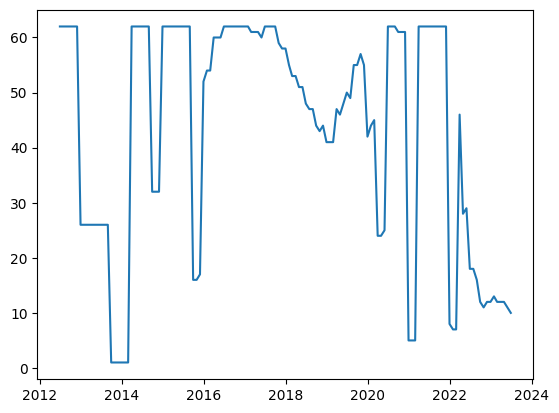

In [ ]:
# I'd like to look at the distribution of "non-zero" (e.g. greater than 0.1%) tickers
plt.plot(mlp_pred_matrix[mlp_pred_matrix > 0.001].nunique(axis=1))

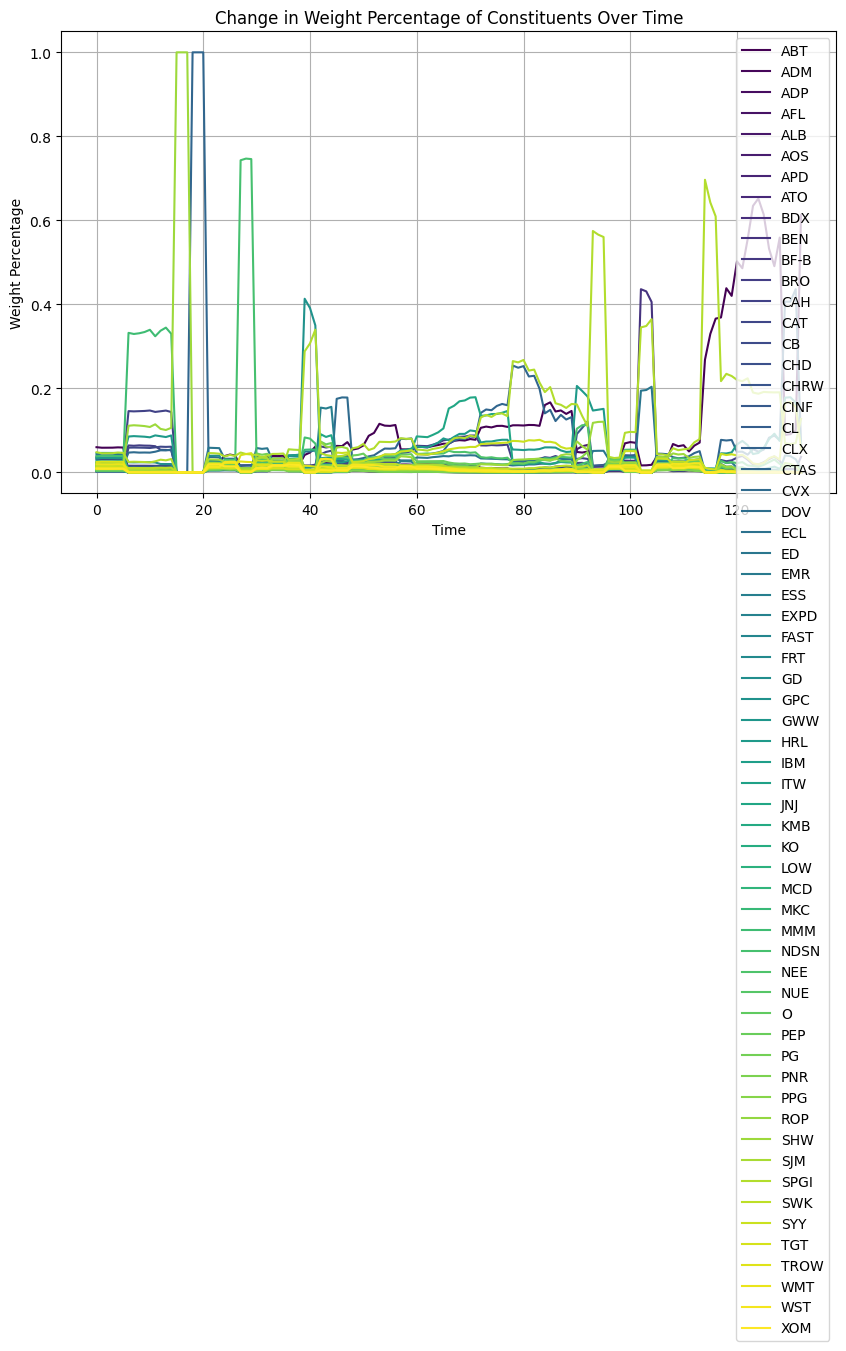

In [ ]:
plt.figure(figsize=(10,6))
for i in range(num_constituents):
  plt.plot(mlp_stacked[:, i], color=colors[i], label=dataset.Ticker[:62][i])

plt.xlabel('Time')
plt.ylabel('Weight Percentage')
plt.title('Change in Weight Percentage of Constituents Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [153]:
ew_pred_matrix = pd.DataFrame(index=mlp_pred_matrix.index, columns=mlp_pred_matrix.columns)
ew_pred_matrix[:] = 1 / len(ew_pred_matrix.columns)
ew_pred_matrix

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2012-07-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2012-08-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2012-09-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2012-10-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2023-03-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2023-04-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


In [ ]:
def perform_backtest(prices, model_preds):
  price_data = prices.drop(['MDT', 'LIN'], axis=1)
  price_data = price_data[price_data.index.isin(date_index[n_train:])]
  price_data = price_data.sort_index()

  p_rets = []
  p_metrics = pd.DataFrame()

  for idx, preds in enumerate(model_preds):
    # portfolio value over time
    portfolio_value = (price_data * preds).sum(axis=1)

    # monthly portfolio returns
    portfolio_returns = portfolio_value.pct_change()
    p_rets.append(portfolio_returns)

    # total return, annualized return, Sharpe ratio, Volatility, Max Drawdown
    totalReturn = portfolio_value[-1] / portfolio_value[0] - 1
    years = len(portfolio_value) / 12
    annualReturn = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / years)) - 1
    monthly_returns = portfolio_value.pct_change()
    sharpeRatio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)
    volatility = monthly_returns.std() * np.sqrt(12)
    cumulative_returns = (1 + monthly_returns).cumprod()
    maxDrawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    nn_metrics = pd.DataFrame({f'NN{idx}':[totalReturn, annualReturn, sharpeRatio, volatility, maxDrawdown]})
    p_metrics = pd.concat([p_metrics, nn_metrics], axis=1)

  p_metrics.index = ['totalReturn', 'annualReturn', 'sharpeRatio', 'volatility', 'maxDrawdown']
  return p_rets, p_metrics

In [154]:
p_rets, p_metrics = perform_backtest(prices=data_m, model_preds=[mlp_pred_matrix, cnn_pred_matrix, rnn_pred_matrix, ew_pred_matrix])
p_rets_df = pd.concat(p_rets, axis=1).dropna()
p_rets_df.columns = ['MLP', 'CNN', 'RNN', 'EW']

<ipython-input-81-adbfca63fe2a>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = portfolio_value[-1] / portfolio_value[0] - 1
<ipython-input-81-adbfca63fe2a>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualReturn = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / years)) - 1
<ipython-input-81-adbfca63fe2a>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = portfolio_value[-1] / portfolio_value[

In [155]:
p_rets_df

,MLP,CNN,RNN,EW
Date,,,,
2012-07-31,0.01,0.02,0.03,0.01
2012-08-31,0.02,0.02,0.01,0.01
2012-09-30,0.02,0.02,0.02,0.02
2012-10-31,-0.00,-0.01,-0.01,-0.01
2012-11-30,0.01,0.01,0.01,0.01
...,...,...,...,...
2023-02-28,-0.08,-0.05,-0.03,-0.01
2023-03-31,0.51,0.69,1.52,0.01
2023-04-30,-0.00,-0.01,-0.03,0.02


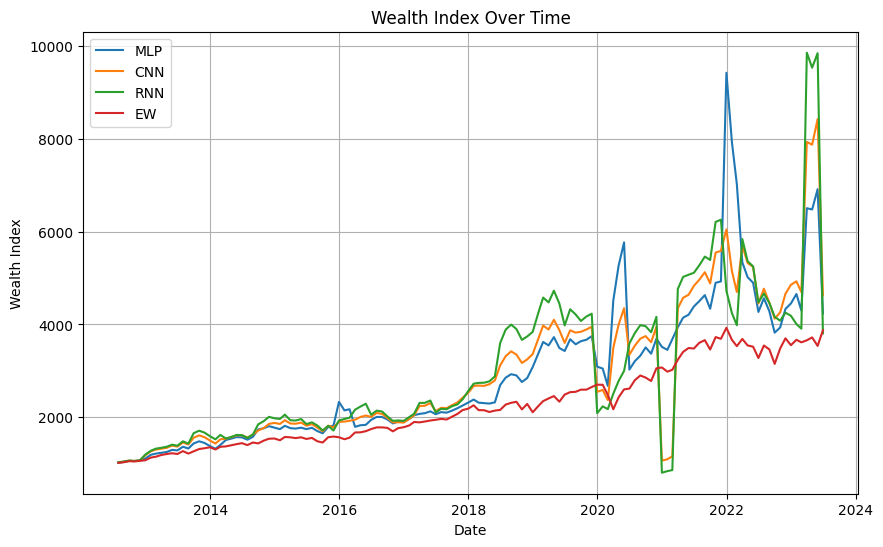

In [156]:
wealth_index = 1000*(1+p_rets_df).cumprod()

plt.figure(figsize=(10, 6))
for column in wealth_index.columns:
    plt.plot(wealth_index.index, wealth_index[column], label=column)

plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.title('Wealth Index Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Reinforcement Learning (RL)

In [115]:
# add covariance matrix as states
rl_df = dataset
rl_df.index = rl_df.Date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=12
for i in range(lookback, len(rl_df.index.unique())):
  data_lookback = rl_df.loc[i-lookback:i,:]
  return_lookback = data_lookback.pivot_table(index = 'Date',columns = 'Ticker', values = 'ret')
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)

df_cov = pd.DataFrame({'Date':rl_df.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
rl_df = rl_df.merge(df_cov, on='Date')
rl_df = rl_df.sort_values(['Date','Ticker']).reset_index(drop=True)
rl_df

,Date,Ticker,ret,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr,cov_list,return_list
0,2011-06-30,ABT,0.01,0.02,0.39,0.88,0.03,0.20,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
1,2011-06-30,ADM,-0.07,0.01,0.27,2.19,0.01,0.02,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
2,2011-06-30,ADP,-0.04,0.01,0.74,0.49,0.01,0.10,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
3,2011-06-30,AFL,-0.02,0.02,0.46,-0.85,0.00,0.05,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
4,2011-06-30,ALB,-0.02,0.00,0.13,0.59,0.03,0.16,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
...,...,...,...,...,...,...,...,...,...,...,...,...
8985,2023-06-30,TGT,0.01,0.01,0.52,1.07,0.02,0.04,5.40,4.49,"[[0.003941050218073522, 0.002496382645067731, ...",Ticker ABT ADM ADP AFL ALB AOS...
8986,2023-06-30,TROW,0.06,0.01,0.59,0.49,0.04,0.30,5.40,4.49,"[[0.003941050218073522, 0.002496382645067731, ...",Ticker ABT ADM ADP AFL ALB AOS...
8987,2023-06-30,WMT,0.07,0.01,0.92,0.13,0.01,0.01,5.40,4.49,"[[0.003941050218073522, 0.002496382645067731, ...",Ticker ABT ADM ADP AFL ALB AOS...
8988,2023-06-30,WST,0.13,0.00,0.09,0.86,0.04,0.21,5.40,4.49,"[[0.003941050218073522, 0.002496382645067731, ...",Ticker ABT ADM ADP AFL ALB AOS...


In [116]:
# monthly price data
price_data = data_m.drop(['MDT', 'LIN'], axis=1)
# price_data = price_data[price_data.index.isin(date_index[n_train:])]
price_data = price_data.sort_index()
price_long = price_data.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='close')

In [117]:
rl_df = price_long.merge(rl_df, on=['Date', 'Ticker']).drop('ret', axis=1)
rl_df = rl_df.sort_values(by=['Date', 'Ticker'])

## Build Environment

In [118]:
train_pct = 0.8
unique_dates = sorted(rl_df.Date.unique())
train_end_date = unique_dates[int(train_pct * len(unique_dates))]

In [119]:
rl_train = rl_df.set_index('Date')
rl_train = rl_train.loc[:train_end_date, :]
rl_train = rl_train.reset_index()
rl_train.index = rl_train.Date.factorize()[0]
rl_train

,Date,Ticker,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr,cov_list,return_list
0,2011-06-30,ABT,19.29,0.02,0.39,0.88,0.03,0.20,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ADM,21.52,0.01,0.27,2.19,0.01,0.02,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ADP,34.43,0.01,0.74,0.49,0.01,0.10,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,AFL,17.00,0.02,0.46,-0.85,0.00,0.05,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ALB,57.81,0.00,0.13,0.59,0.03,0.16,0.19,0.81,"[[0.002305633107305053, 0.0018351510800580179,...",Ticker ABT ADM ADP AFL ALB AOS...
...,...,...,...,...,...,...,...,...,...,...,...,...
116,2021-02-28,TGT,171.00,0.00,0.34,0.11,0.02,0.05,0.08,0.30,"[[0.005868428773539263, 0.002549252305522153, ...",Ticker ABT ADM ADP AFL ALB AOS...
116,2021-02-28,TROW,141.71,0.01,0.27,0.00,0.07,0.45,0.08,0.30,"[[0.005868428773539263, 0.002549252305522153, ...",Ticker ABT ADM ADP AFL ALB AOS...
116,2021-02-28,WMT,41.20,0.01,0.30,0.11,0.02,0.04,0.08,0.30,"[[0.005868428773539263, 0.002549252305522153, ...",Ticker ABT ADM ADP AFL ALB AOS...
116,2021-02-28,WST,278.62,0.00,0.13,1.10,0.04,0.17,0.08,0.30,"[[0.005868428773539263, 0.002549252305522153, ...",Ticker ABT ADM ADP AFL ALB AOS...


In [145]:
rl_train['cov_list'].values

array([array([[ 2.30563311e-03,  1.83515108e-03,  7.87180552e-04, ...,
                3.64653784e-04,  4.11071718e-04, -1.27039743e-05],
              [ 1.83515108e-03,  7.22867942e-03,  4.96284717e-04, ...,
               -1.32015076e-04, -7.22709183e-04,  1.84147185e-03],
              [ 7.87180552e-04,  4.96284717e-04,  1.80600388e-03, ...,
                9.39032283e-04,  1.64607032e-03,  1.13379875e-03],
              ...,
              [ 3.64653784e-04, -1.32015076e-04,  9.39032283e-04, ...,
                1.88519255e-03,  7.64628093e-04,  7.93896377e-04],
              [ 4.11071718e-04, -7.22709183e-04,  1.64607032e-03, ...,
                7.64628093e-04,  3.28223593e-03,  1.30006333e-03],
              [-1.27039743e-05,  1.84147185e-03,  1.13379875e-03, ...,
                7.93896377e-04,  1.30006333e-03,  2.39286292e-03]])   ,
       array([[ 2.30563311e-03,  1.83515108e-03,  7.87180552e-04, ...,
                3.64653784e-04,  4.11071718e-04, -1.27039743e-05],
          

In [133]:
# rl_df.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/rl_df.csv", index=False)
# rl_train.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/rl_train.csv")

In [126]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax, # max number of shares to trade
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=12,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]


    def step(self, actions):
        # print(self.day)
        # ipdb.set_trace()
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['monthly_return']
            plt.plot(df.monthly_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_monthly_return = pd.DataFrame(self.portfolio_return_memory)
            df_monthly_return.columns = ['monthly_return']
            if df_monthly_return['monthly_return'].std() !=0:
              sharpe = (12**0.5)*df_monthly_return['monthly_return'].mean()/ \
                       df_monthly_return['monthly_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            print(self.state)
            print(self.reward)
            print(self.terminal)
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.Date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling
            print(self.state)
            print(self.reward)
            print(self.terminal)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # ipdb.set_trace()
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]
        print(self.state)
        return self.state

    def render(self, mode='human'):
        # ipdb.set_trace()
        return self.state

    def softmax_normalization(self, actions):
        # ipdb.set_trace()
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        # ipdb.set_trace()
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # ipdb.set_trace()
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['Date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.Date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        # ipdb.set_trace()
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        # ipdb.set_trace()
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [127]:
stock_dimension = len(rl_train.Ticker.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 62, State Space: 62


In [128]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": rl_train.columns[3:10],
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = rl_train, **env_kwargs)

In [129]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

[[ 2.30563311e-03  1.83515108e-03  7.87180552e-04 ...  3.64653784e-04
   4.11071718e-04 -1.27039743e-05]
 [ 1.83515108e-03  7.22867942e-03  4.96284717e-04 ... -1.32015076e-04
  -7.22709183e-04  1.84147185e-03]
 [ 7.87180552e-04  4.96284717e-04  1.80600388e-03 ...  9.39032283e-04
   1.64607032e-03  1.13379875e-03]
 ...
 [ 2.04655072e-01  1.66593791e-02  9.64460931e-02 ...  3.26234055e-02
   6.62710188e-02  2.59854015e+01]
 [ 1.90000000e-01  1.90000000e-01  1.90000000e-01 ...  1.90000000e-01
   1.90000000e-01  1.90000000e-01]
 [ 8.10000000e-01  8.10000000e-01  8.10000000e-01 ...  8.10000000e-01
   8.10000000e-01  8.10000000e-01]]
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Use Different Agents

In [130]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

# this can be done for other agents plus custom agents as well
# custom will be important depending upon how we try new things

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [131]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=5000)

[[ 2.30563311e-03  1.83515108e-03  7.87180552e-04 ...  3.64653784e-04
   4.11071718e-04 -1.27039743e-05]
 [ 1.83515108e-03  7.22867942e-03  4.96284717e-04 ... -1.32015076e-04
  -7.22709183e-04  1.84147185e-03]
 [ 7.87180552e-04  4.96284717e-04  1.80600388e-03 ...  9.39032283e-04
   1.64607032e-03  1.13379875e-03]
 ...
 [ 2.04655072e-01  1.66593791e-02  9.64460931e-02 ...  3.26234055e-02
   6.62710188e-02  2.59854015e+01]
 [ 1.90000000e-01  1.90000000e-01  1.90000000e-01 ...  1.90000000e-01
   1.90000000e-01  1.90000000e-01]
 [ 8.10000000e-01  8.10000000e-01  8.10000000e-01 ...  8.10000000e-01
   8.10000000e-01  8.10000000e-01]]
[[ 2.30308584e-03  1.86630693e-03  8.20938716e-04 ...  2.68144495e-04
   2.26145830e-04 -1.00698844e-04]
 [ 1.86630693e-03  7.22861201e-03  5.38941635e-04 ... -8.93188187e-05
  -6.67654543e-04  1.91691698e-03]
 [ 8.20938716e-04  5.38941635e-04  1.90331496e-03 ...  8.57698230e-04
   1.45822893e-03  1.10330128e-03]
 ...
 [ 2.04655072e-01  1.66593791e-02  9.6446093

ValueError: setting an array element with a sequence.

> /usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py(58)step_wait()
     56         # Avoid circular imports
     57         for env_idx in range(self.num_envs):
---> 58             obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
     59                 self.actions[env_idx]
     60             )




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [ ]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Build custom agent with embargo/purging/CPCV?

## Backtest Models

# Compare Results from RL vs. NNs vs. MVO